In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil
from models.enums.chartType import TrainingCharts
import torch
from metrics.accuracy import get_accuracy
from metrics.modelAnalysisUtils import ModelAnalysisUtils
from models.modelAnalysis.multiRunAnalysis import MultiRunAnalysis
from matplotlib import pyplot as plt
import seaborn as sns
from models.enums.similarityType import AbsSimilarityType
import numpy as np
import pandas as pd
from utils.seedGenerator import generate_seeds

In [11]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique=False)
trainUtil_2dXOR_identicalsplit = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [12]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

model_types_sparse_permut = {"Complete Sparse Model": model_params_all, 
               "1st L Sparse Model": model_params_first, 
               "2nd L Sparse Model": model_params_second,
               "3rd L Sparse Model": model_params_third,
               "1st and 2nd L Sparse Model": model_params_first_second,
               "1st and 3rd L Sparse Model": model_params_first_third,
               "2nd and 3rd L Sparse Model": model_params_second_third
            }

In [13]:
multi_run_analysis_3l_2d = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
experiment_3l_2d_simmilarity = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()

In [14]:
def get_models(experiment: RunExperiment, 
               modelSetups: ModelSetups, 
               modelTypes: dict[str, dict[str, tuple[int, int]]],
               layers: int, 
               needTrainActivations = False, 
               batch_train = True, 
               in_features = 2,
               n_epochs = 150,
               seed = 0,
               lr = 0.01,):
    out_features = 2
    dense_control_key = list(modelTypes.keys())[0]
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            # "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers,  
        model_params = modelTypes[dense_control_key],
        n_epochs=n_epochs,
        batch_train=batch_train,
        return_train_acts = needTrainActivations,
        seed = seed,
        lr = lr
    )

    for modelName in modelTypes:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = modelTypes[modelName],
            n_epochs = n_epochs,
            batch_train=batch_train,
            return_train_acts = needTrainActivations,
            seed = seed,
            lr = lr
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [15]:
n_runs = 50
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_3l_2d_simmilarity,
                                                                  modelSetups, 
                                                                  model_types_sparse_permut,
                                                                  layers, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_3l_2d.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_3l_2d.add_run_train_data_dummy(trainActivations, X_train, y_train)

In [56]:
train_dfs_2d = modelAnalysisUtils.create_train_pr_df_multi_run(multi_run_analysis_3l_2d, needBootstrapped=True)

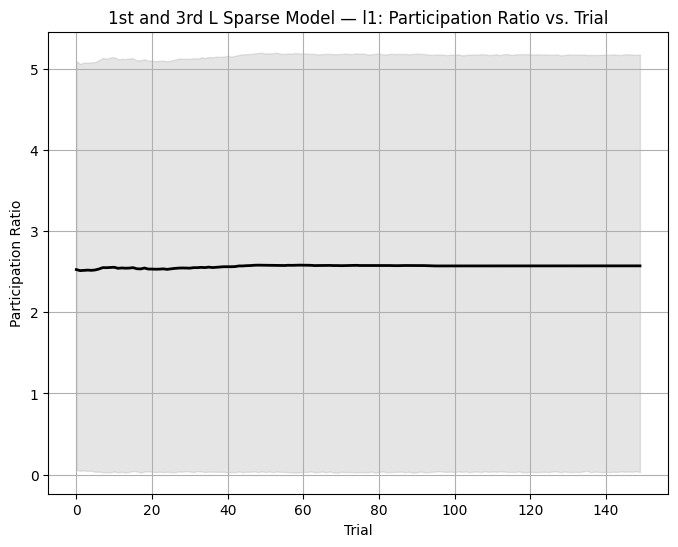

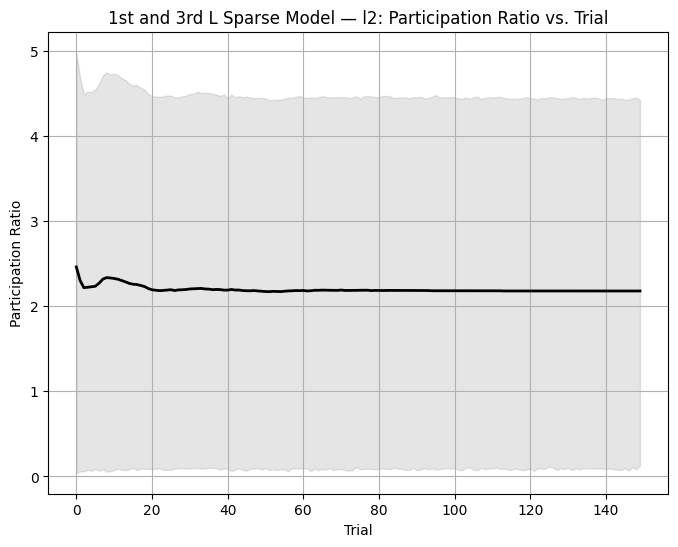

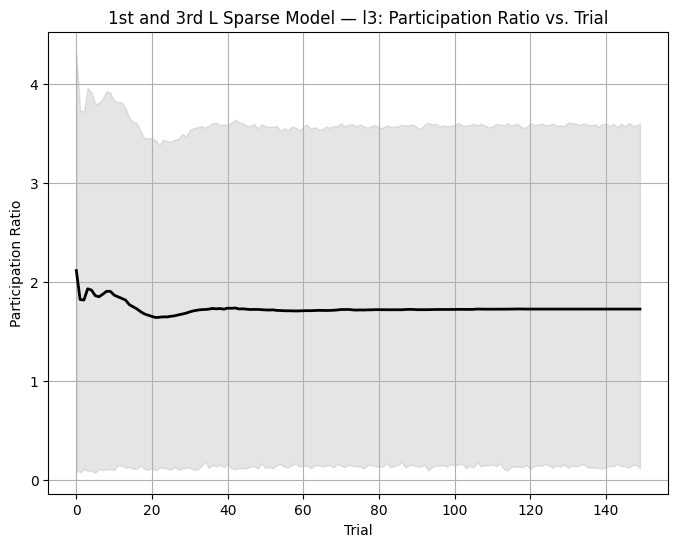

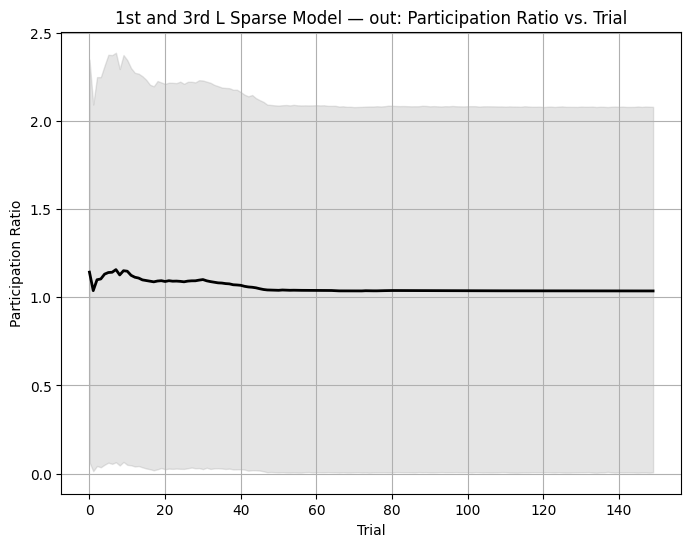

In [64]:
model_to_plot = "1st and 3rd L Sparse Model"

for layer_name, (df_mean, df_ci) in train_dfs_2d[model_to_plot].items():
    n_models = len(train_dfs_2d[model_to_plot])
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models

    epochs = df_mean.index
    mean_vals = df_mean["participation_ratio"]
    ci_lb = df_ci["ci_low"]
    ci_ub = df_ci["ci_up"]
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None

    ax.tick_params(axis='both', which='major')

    ax.plot(
        epochs, mean_vals, label=f"{layer_name} - Participation Ratio", color="black", linewidth=2
    )

    ax.fill_between(
        epochs,
        mean_vals - ci_lb,
        mean_vals + ci_ub,
        alpha=0.2,
        color="gray",
        label="Train 95% CI"
    )

    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Participation Ratio vs. Trial")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Participation Ratio")
    ax.grid(True)
    plt.show()


In [117]:
from datasets.dymmyProblem import DummyDataset


dataset = DummyDataset()
X_train, y_train, X_val, y_val = dataset.get_dataset(original_split= False, unique = True)
in_features = len(X_train[0])
out_features = 2
trainUtil_7d_dummy = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil_7d_dummy)
modelSetups = ModelSetups()
trainUtil_7d_dummy.set_data_granularity(10)

In [118]:
multi_run_analysis_3l_7d = MultiRunAnalysis()
multi_run_analysis_3l_7d_test = MultiRunAnalysis()
multi_run_analysis_3l_7d_train_test = MultiRunAnalysis()
multi_run_analysis_3l_7d_train_test_train_centered = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
experiment_3l_7d_pr = RunExperiment(trainUtil_7d_dummy)
modelSetups = ModelSetups()

In [119]:
def combine_activations(train_activations, test_activations, dim=0):
    combined = {}

    for model_name in train_activations:
        combined[model_name] = {}

        for epoch in train_activations[model_name]:
            combined[model_name][epoch] = {}

            for layer in train_activations[model_name][epoch]:
                train_tensor = train_activations[model_name][epoch][layer]
                test_tensor = test_activations[model_name][epoch][layer]

                combined_tensor = torch.cat([train_tensor, test_tensor], dim=dim)
                combined[model_name][epoch][layer] = combined_tensor

    return combined

In [122]:
n_runs = 5
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_3l_7d_pr,
                                                                  modelSetups, 
                                                                  model_types_sparse_permut,
                                                                  layers = 3,
                                                                  in_features = 7,
                                                                  n_epochs=250,
                                                                  lr=0.005, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)

    multi_run_analysis_3l_7d.add_run_train_data_dummy(trainActivations, X_train, y_train)
    multi_run_analysis_3l_7d_test.add_run_train_data_dummy(testActivations, X_val, y_val, centering_activations = trainActivations)

    combinedActivations = combine_activations(trainActivations, testActivations, dim=0)

    multi_run_analysis_3l_7d_train_test.add_run_train_data_dummy(combinedActivations, X_val, y_val)
    multi_run_analysis_3l_7d_train_test_train_centered.add_run_train_data_dummy(combinedActivations, X_val, y_val, centering_activations = trainActivations)
    print(f"Run number {i} completed")

Run number 0 completed
Complete Sparse Model 0.800000011920929
Run number 1 completed
Dense Model 0.75
2nd L Sparse Model 0.949999988079071
3rd L Sparse Model 0.8999999761581421
Run number 2 completed
Dense Model 0.800000011920929
3rd L Sparse Model 0.8999999761581421
Run number 3 completed
1st and 2nd L Sparse Model 0.949999988079071
Run number 4 completed


In [125]:
trainActivations["Dense Model"][0]["l1"].shape

torch.Size([20, 200])

In [97]:
train_dfs_7d_train = modelAnalysisUtils.create_train_pr_df_multi_run(multi_run_analysis_3l_7d, needBootstrapped=True)
train_dfs_7d_test = modelAnalysisUtils.create_train_pr_df_multi_run(multi_run_analysis_3l_7d_test, needBootstrapped=True)
train_dfs_7d_train_test = modelAnalysisUtils.create_train_pr_df_multi_run(multi_run_analysis_3l_7d_train_test, needBootstrapped=True)
train_dfs_7d_train_test_train_centered = modelAnalysisUtils.create_train_pr_df_multi_run(multi_run_analysis_3l_7d_train_test_train_centered, needBootstrapped=True)

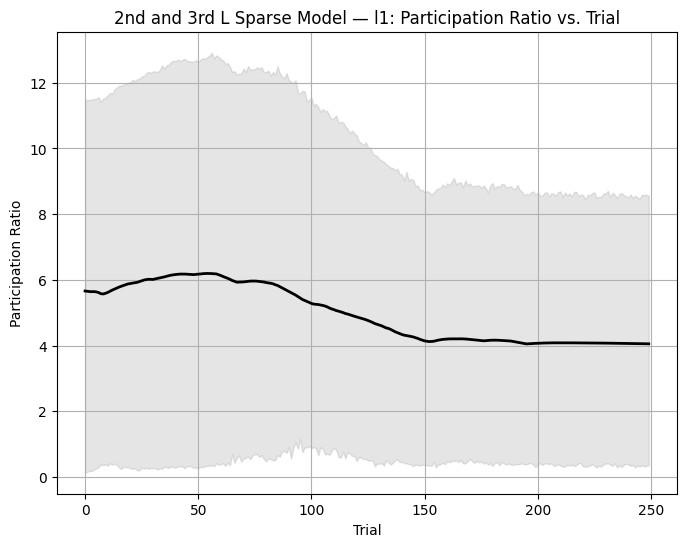

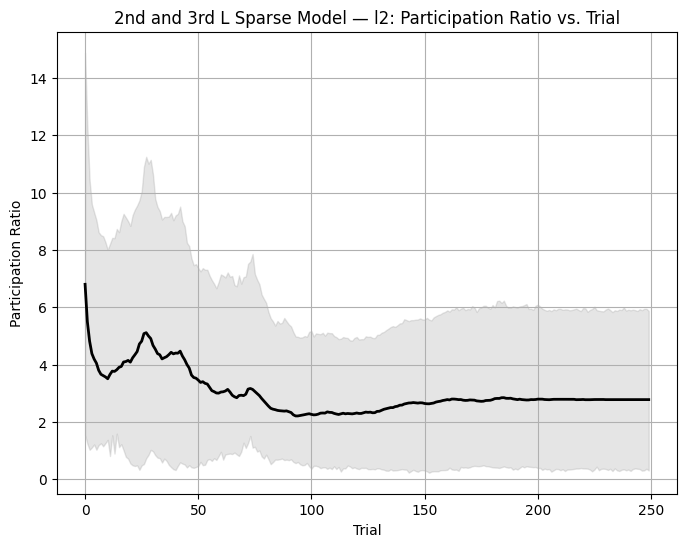

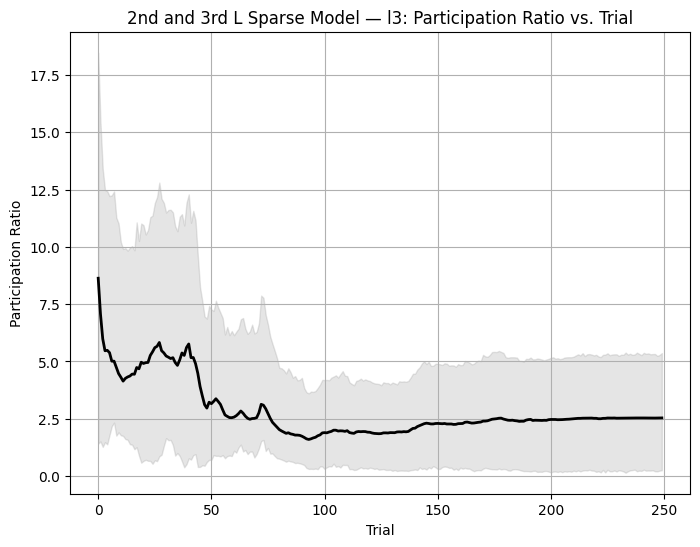

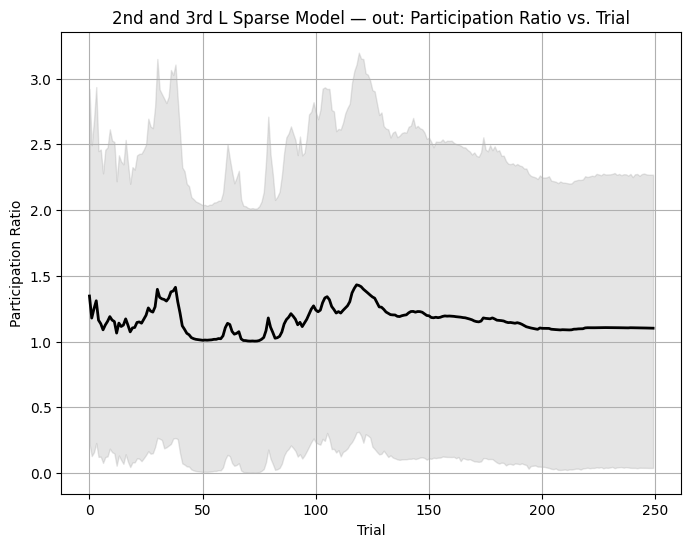

In [54]:
model_to_plot = "2nd and 3rd L Sparse Model"

for layer_name, (df_mean, df_ci) in train_dfs_7d_train[model_to_plot].items():
    n_models = len(train_dfs_7d_train[model_to_plot])
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models

    epochs = df_mean.index
    mean_vals = df_mean["participation_ratio"]
    ci_lb = df_ci["ci_low"]
    ci_ub = df_ci["ci_up"]
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None

    ax.tick_params(axis='both', which='major')

    ax.plot(
        epochs, mean_vals, label=f"{layer_name} - Participation Ratio", color="black", linewidth=2
    )

    ax.fill_between(
        epochs,
        mean_vals - ci_lb,
        mean_vals + ci_ub,
        alpha=0.2,
        color="gray",
        label="Train 95% CI"
    )

    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Participation Ratio vs. Trial")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Participation Ratio")
    ax.grid(True)
    plt.show()
   

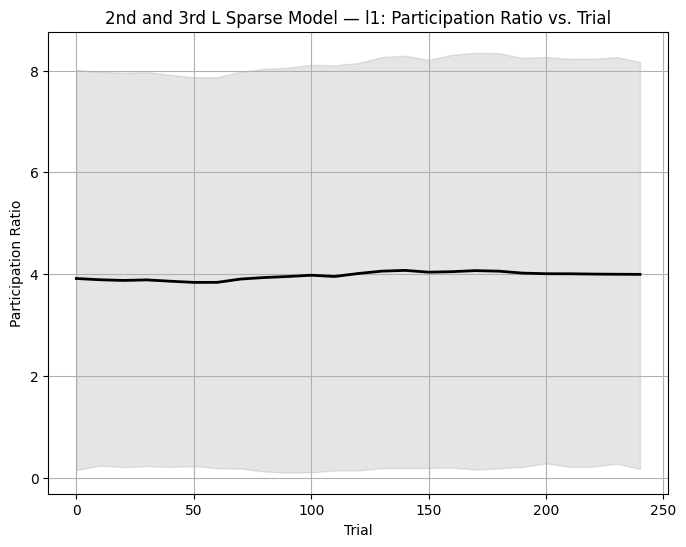

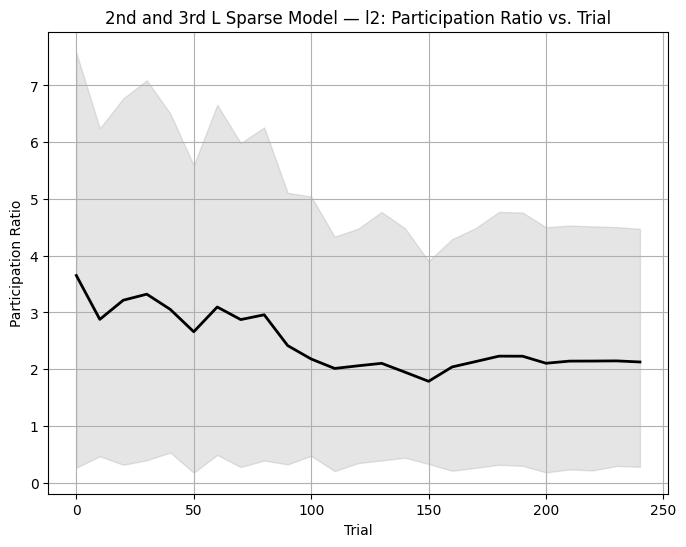

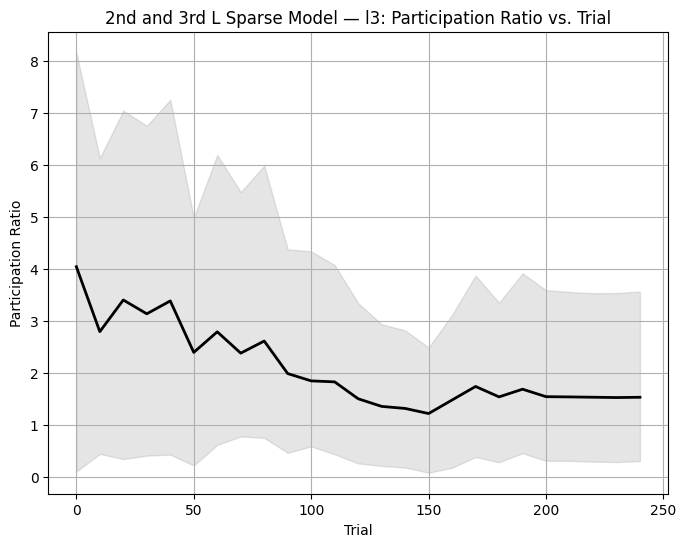

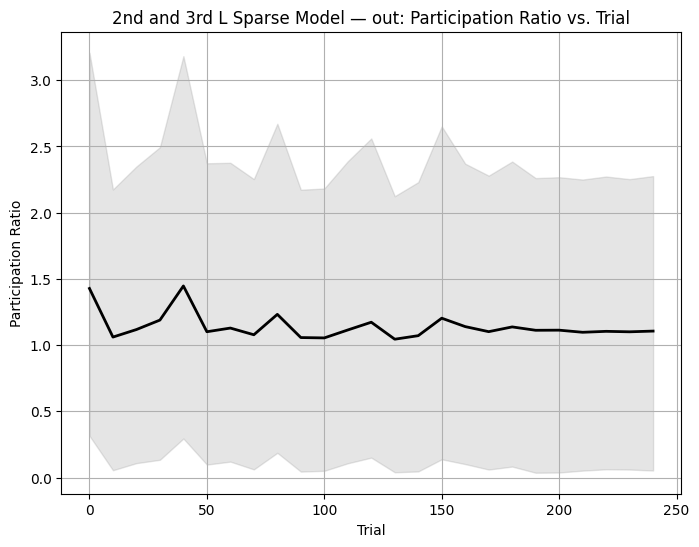

In [116]:
model_to_plot = "2nd and 3rd L Sparse Model"

for layer_name, (df_mean, df_ci) in train_dfs_7d_test[model_to_plot].items():
    n_models = len(train_dfs_7d_test[model_to_plot])
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models

    epochs = df_mean.index
    mean_vals = df_mean["participation_ratio"]
    ci_lb = df_ci["ci_low"]
    ci_ub = df_ci["ci_up"]
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None

    ax.tick_params(axis='both', which='major')

    ax.plot(
        epochs, mean_vals, label=f"{layer_name} - Participation Ratio", color="black", linewidth=2
    )

    ax.fill_between(
        epochs,
        mean_vals - ci_lb,
        mean_vals + ci_ub,
        alpha=0.2,
        color="gray",
        label="Train 95% CI"
    )

    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Participation Ratio vs. Trial")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Participation Ratio")
    ax.grid(True)
    plt.show()
   